In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [143]:
df=pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")

In [144]:
df.head(10)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [145]:
df.shape

(144, 2)

In [146]:
df["Month"] = pd.to_datetime(df["Month"]) #column to datetime

In [147]:
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [148]:
df = df.set_index("Month")

In [149]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0, 0.5, 'Passengers')

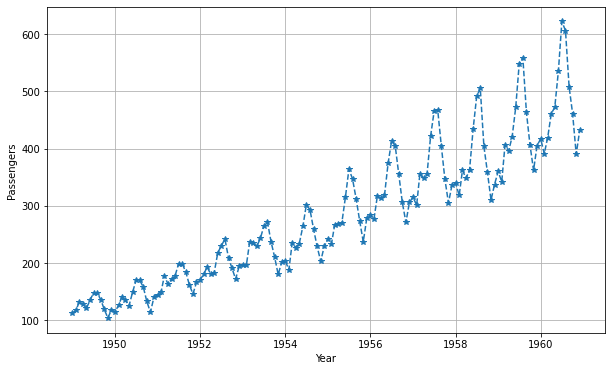

In [150]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df.Passengers, '--', marker='*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')

In [151]:
df_copy = df.copy()
rows = df_copy.sample(frac=0.1, random_state=0)
rows['Passengers'] = np.nan
df_copy.loc[rows.index, 'Passengers'] = rows['Passengers']
df_copy.isnull().sum()
#There are now 14 missing values in the dataset

Passengers    14
dtype: int64

In [152]:
df_copy_ffill = df_copy.fillna(method='ffill')
df_copy_ffill.isnull().sum()

Passengers    0
dtype: int64

In [153]:
 #Backward fill
df_copy_bfill = df_copy.fillna(method='bfill')
df_copy_bfill.isnull().sum()

Passengers    0
dtype: int64

In [154]:
#Filling missing data by interpolation
df_copy_LIF = df_copy.interpolate(method='linear', limit_direction='forward')
df_copy_LIF.isnull().sum()
df_copy_LIB = df_copy.interpolate(method='linear', limit_direction='backward')
df_copy_LIB.isnull().sum()

Passengers    0
dtype: int64

In [155]:
df_MA = df.copy()
MA = df_MA['Passengers'].rolling(12).mean()

In [156]:
import statsmodels.api as sm
from pylab import rcParams

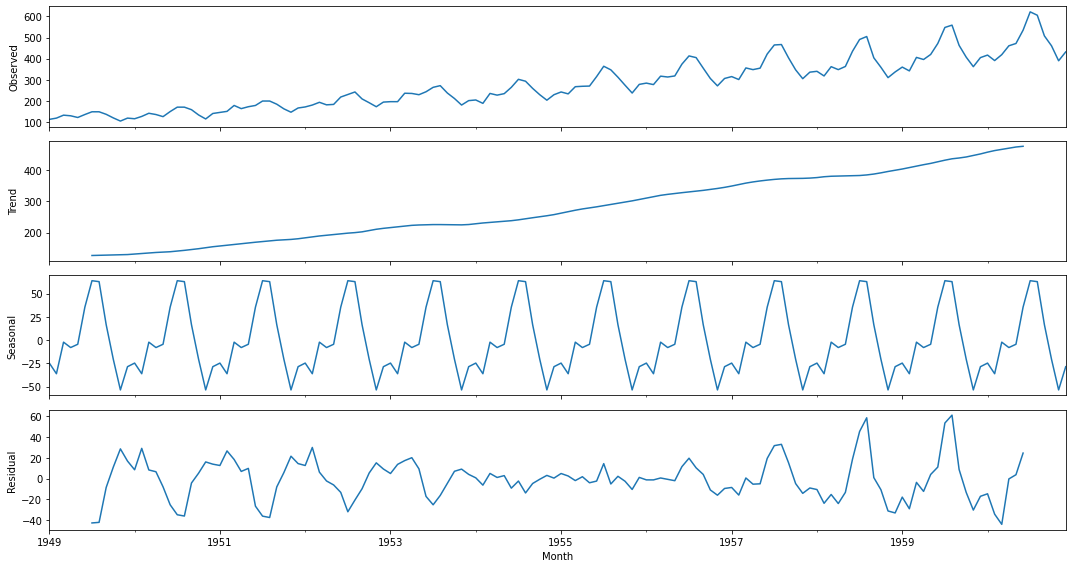

In [157]:
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(df['Passengers'], model='additive')
decompose_series.plot()
plt.show()

In [158]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['Passengers'])

In [159]:
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f'   {k}: {v}') 

ADF Statistic: 0.8153688792060418
p-value: 0.9918802434376409
No. of lags used: 13
No. of observations used : 130
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


In [160]:
df_log = np.log(df)
df_diff = df_log.diff(periods=1)

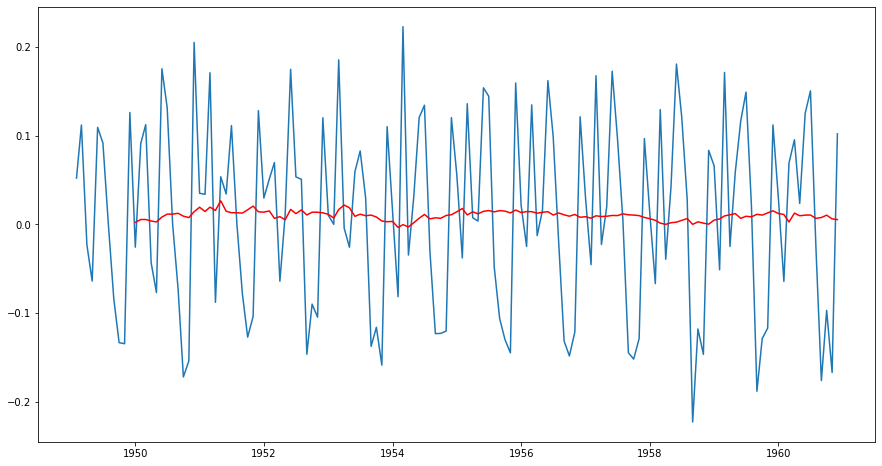

In [161]:
plt.plot(df_diff.index, df_diff.Passengers, '-')
plt.plot(df_diff.rolling(12).mean(), color='red')

In [162]:
#Downsample to quarterly data points
df_quarterly = df.resample('3M').mean()

#Upsample to daily data points
df_daily = df.resample('D').mean()

In [163]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [164]:
df_diff.isnull().sum()

Passengers    1
dtype: int64

In [165]:
df_diff = df_diff.fillna(method='bfill')

In [166]:
df_diff.isnull().sum()

Passengers    0
dtype: int64

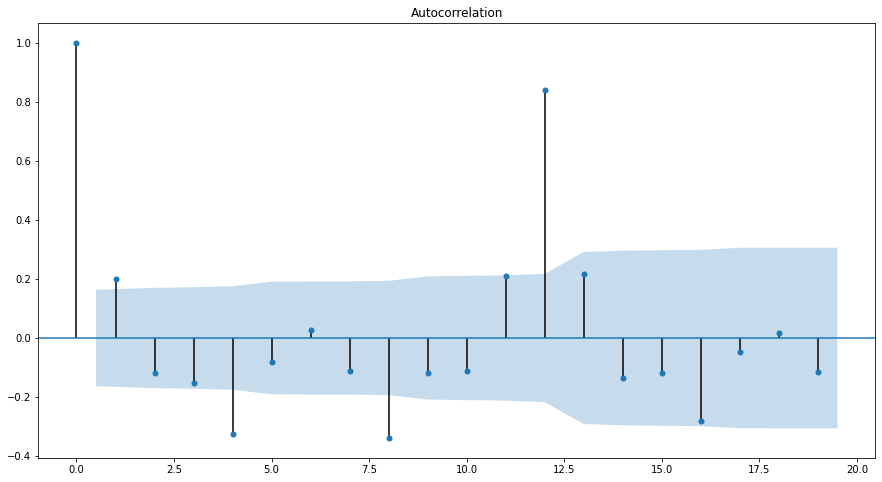

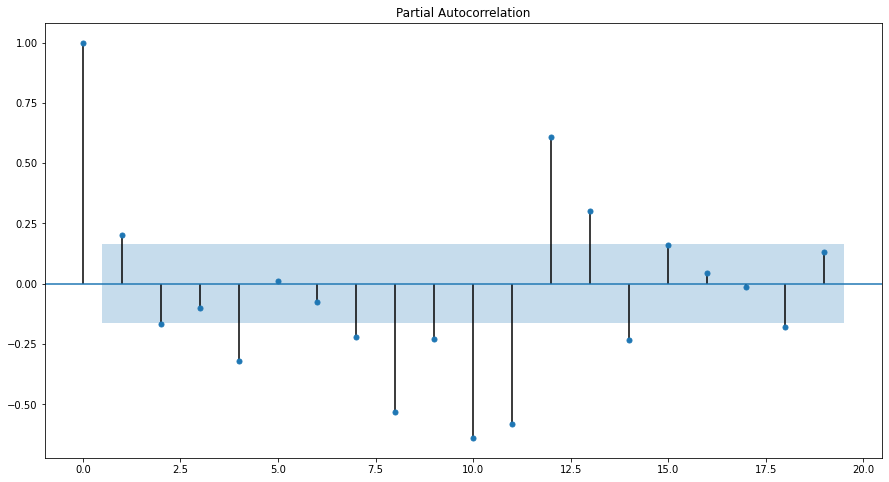

In [167]:
#ACF
plot_acf(df_diff, lags = range(0, 20))
plt.show()
#PACF
plot_pacf(df_diff, lags = range(0, 20))
plt.show()

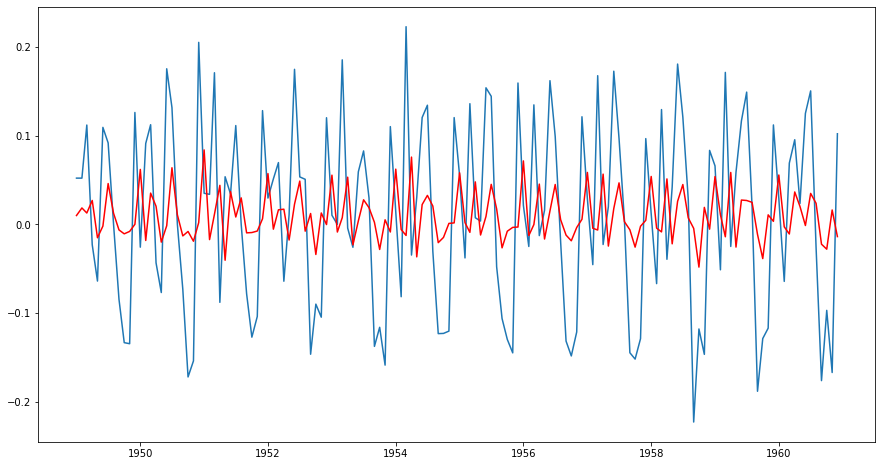

In [168]:
#AR, MA and ARIMA
from statsmodels.tsa.arima_model import ARIMA
#(p,d,q)
AR_model = ARIMA(df_diff, order=(2,0,0))
AR_model_results = AR_model.fit()
plt.plot(df_diff)
plt.plot(AR_model_results.fittedvalues, color='red')

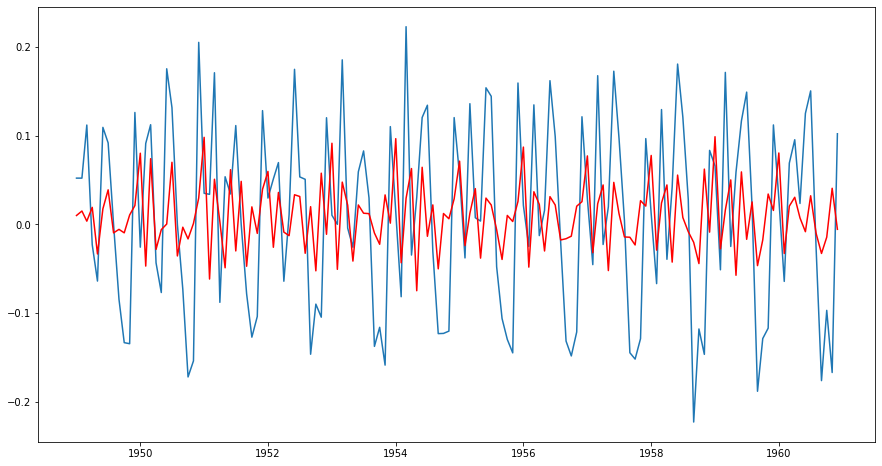

In [169]:
MA_model = ARIMA(df_diff, order=(0,0,2))
MA_model_results = MA_model.fit()
plt.plot(df_diff)
plt.plot(MA_model_results.fittedvalues, color='red')

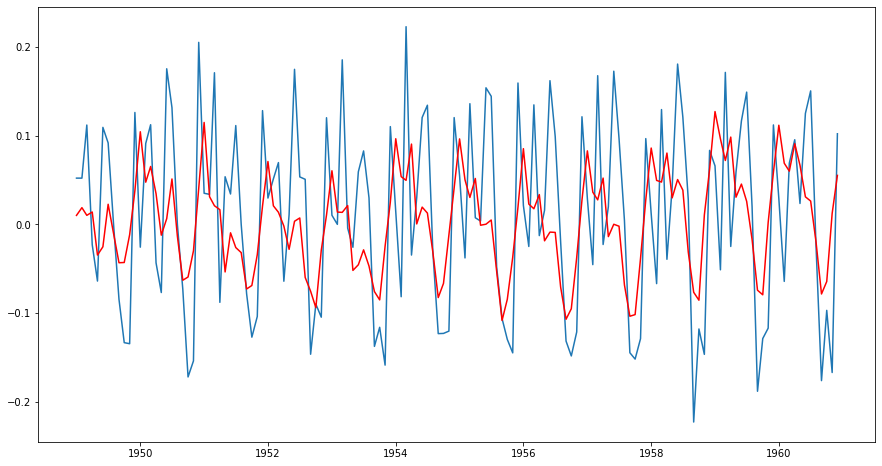

In [170]:
ARIMA_model = ARIMA(df_diff, order=(2,0,1))
ARIMA_results = ARIMA_model.fit()
plt.plot(df_diff)
plt.plot(ARIMA_results.fittedvalues, color='red')

In [171]:
from fbprophet import Prophet

In [172]:
df=pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")

In [173]:
df['Month']= pd.to_datetime(df['Month'])

In [174]:
df = df.rename(columns={"Month": "ds", "Passengers": "y"})

In [175]:
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [176]:
model = Prophet(weekly_seasonality=True,daily_seasonality=True)
model.fit(df)

In [177]:
#next 10 months prediction 
future = model.make_future_dataframe(periods=10, freq='M') 
forecast = model.predict(future) 
forecast.head()
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,1949-01-01,86.574797,58.019176,115.657902,110.875972,110.875972,110.875972
1,1949-02-01,75.609450,45.510187,101.838811,113.032940,113.032940,113.032940
2,1949-03-01,107.282155,77.183859,137.772995,114.981170,114.981170,114.981170
3,1949-04-01,112.677111,84.879093,142.331875,117.138138,117.138138,117.138138
4,1949-05-01,110.280174,82.518203,138.491983,119.225527,119.225527,119.225527
...,...,...,...,...,...,...,...
149,1961-05-31,534.948151,505.949211,562.350687,506.714342,506.532897,506.872551
150,1961-06-30,581.114309,552.342809,611.020993,509.737305,509.493956,509.952956
151,1961-07-31,574.115856,544.877287,602.707998,512.861033,512.555212,513.146754
152,1961-08-31,530.686669,503.138284,555.872521,515.984761,515.604540,516.318896


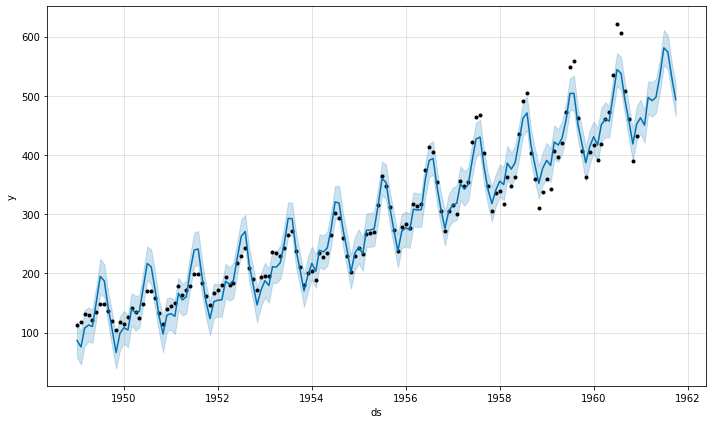

In [178]:
model.plot(forecast)
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Stage E Quiz

In [179]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [180]:
#Reading Dataset 
df = pd.read_csv('household_power_consumption.txt', sep=';',dtype = float ,na_values = '?',infer_datetime_format=True,
                 parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [181]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [182]:
df.shape

(2075259, 7)

In [183]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [184]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [185]:
df2 = df.fillna(df.mean())

In [186]:
def fillmissing(values):
  one_day = 60 *24
  for row in range(values.shape[0]):
    for col in range(values.shape[1]):
      if isnan(values[row,col]):
        values[row, col] = values[row - one_day, col]

In [187]:
print(df2.isnull().sum())
df2.head()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [188]:

#resampling daily method
daily_df = df2.resample('D').sum()
print(daily_df.shape)
daily_df.head(3)

(1442, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0


In [189]:
# Augmented Dickey-Fuller Test (ADF Test) to check for stationarity in data
from statsmodels.tsa.stattools import adfuller

#since we have several samples of time series lets define a function that could check for
#stationarity and output the various columns that are stationary in the series.

def adf_test(d_set):
    dftest = adfuller(d_set, autolag='AIC')
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")
      
#this function takes a time series datframe and checks the columns that are stationary.
def get_stationarity(data):
    for i in data.columns:
        print("Column: ",i)
        print('*'*50)
        adf_test(data[i])

In [190]:
get_stationarity(daily_df) #calling the function to test for stationarity

Column:  Global_active_power
**************************************************
Test Statistic            -3.731704
p-value                    0.003689
# Lags                    22.000000
# Observations          1419.000000
Critical Value (1%)       -3.434967
Critical Value (5%)       -2.863579
Critical Value (10%)      -2.567856
dtype: float64

Series is Stationary
Column:  Global_reactive_power
**************************************************
Test Statistic            -3.825851
p-value                    0.002654
# Lags                    22.000000
# Observations          1419.000000
Critical Value (1%)       -3.434967
Critical Value (5%)       -2.863579
Critical Value (10%)      -2.567856
dtype: float64

Series is Stationary
Column:  Voltage
**************************************************
Test Statistic            -2.959237
p-value                    0.038881
# Lags                    23.000000
# Observations          1418.000000
Critical Value (1%)       -3.434970
Critical Val

In [191]:
roll_mean = daily_df.rolling(window = 365).mean()
roll_std = daily_df.rolling(window = 365).std()

In [192]:
plt.rcParams['figure.figsize'] = 15,8

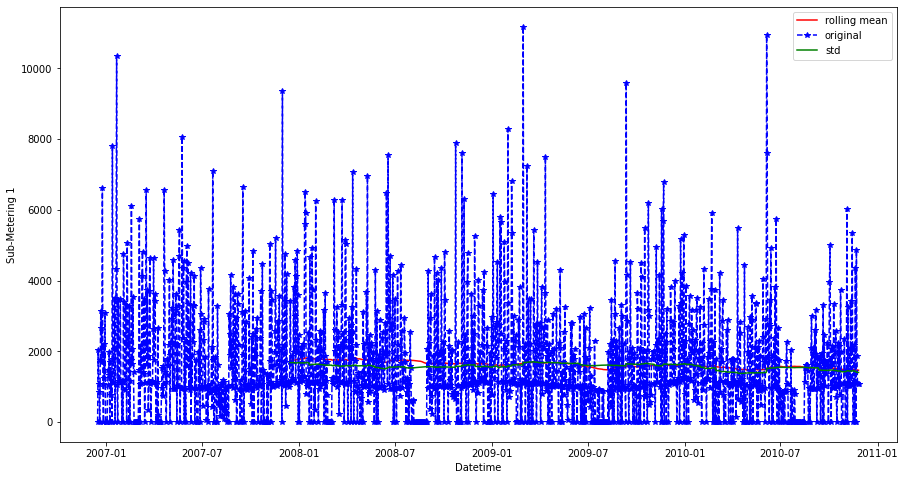

In [193]:
mean = plt.plot(roll_mean.index, roll_mean.Sub_metering_1, color = 'red',label = 'rolling mean')
original = plt.plot(daily_df.index, daily_df.Sub_metering_1,'--', marker='*', color = 'blue',label = 'original')
std = plt.plot(roll_std.index, roll_std.Sub_metering_1, color = 'green', label = 'std')
plt.legend(loc = 'best')
plt.xlabel('Datetime')
plt.ylabel('Sub-Metering 1')
plt.show()

Text(0, 0.5, 'Global Active Power')

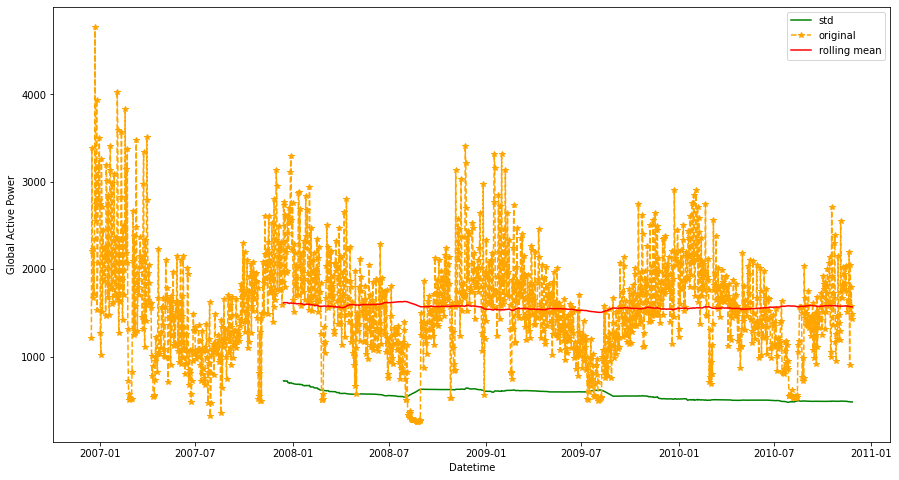

In [194]:
std = plt.plot(roll_std.index, roll_std.Global_active_power, color = 'green', label = 'std')
original = plt.plot(daily_df.index, daily_df.Global_active_power,'--', marker='*', color = 'orange',label = 'original')
mean = plt.plot(roll_mean.index, roll_mean.Global_active_power, color = 'red',label = 'rolling mean')
plt.legend(loc = 'best')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power')

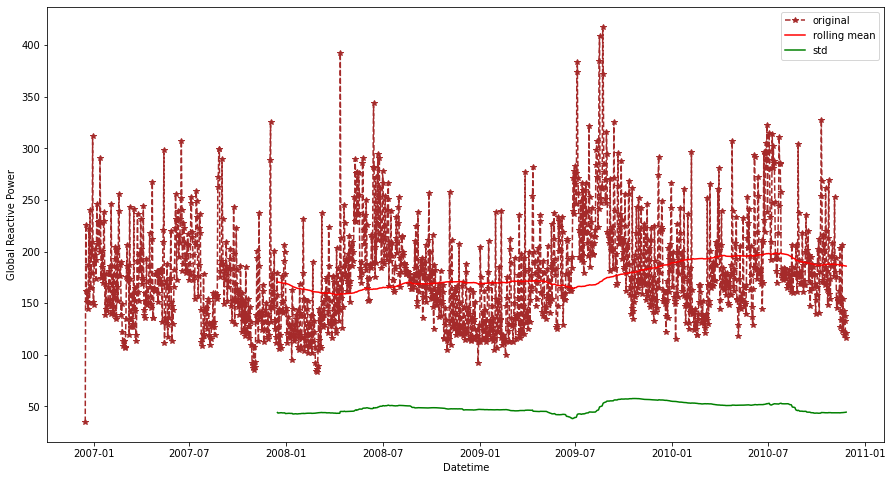

In [195]:
original = plt.plot(daily_df.index, daily_df.Global_reactive_power,'--', marker='*', color = 'brown',label = 'original')
mean = plt.plot(roll_mean.index, roll_mean.Global_reactive_power, color = 'red',label = 'rolling mean')
std = plt.plot(roll_std.index, roll_std.Global_reactive_power, color = 'green', label = 'std')
plt.legend(loc = 'best')
plt.xlabel('Datetime')
plt.ylabel('Global Reactive Power')
plt.show()

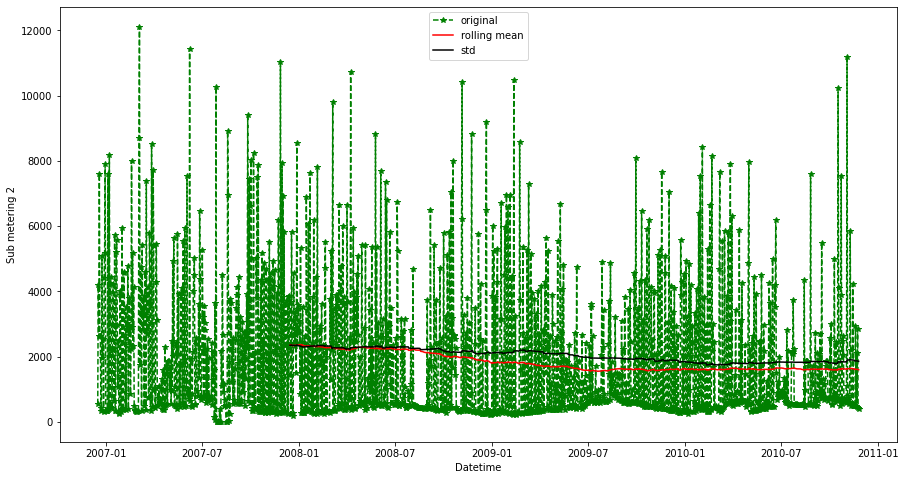

In [196]:
original = plt.plot(daily_df.index, daily_df.Sub_metering_2,'--', marker='*', color = 'green',label = 'original')
mean = plt.plot(roll_mean.index, roll_mean.Sub_metering_2, color = 'red',label = 'rolling mean')
std = plt.plot(roll_std.index, roll_std.Sub_metering_2, color = 'black', label = 'std')
plt.legend(loc = 'best')
plt.xlabel('Datetime')
plt.ylabel('Sub metering 2')
plt.show()

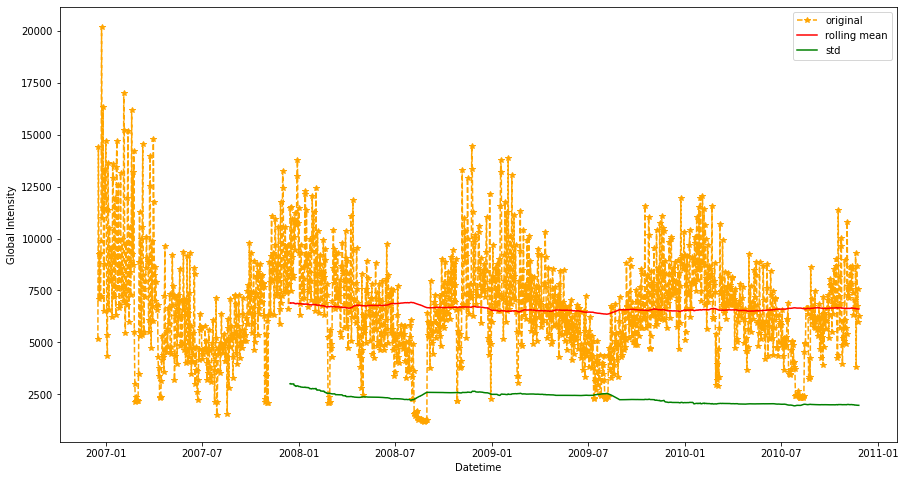

In [197]:
original = plt.plot(daily_df.index, daily_df.Global_intensity,'--', marker='*', color = 'orange',label = 'original')
mean = plt.plot(roll_mean.index, roll_mean.Global_intensity, color = 'red',label = 'rolling mean')
std = plt.plot(roll_std.index, roll_std.Global_intensity, color = 'green', label = 'std')
plt.legend(loc = 'best')
plt.xlabel('Datetime')
plt.ylabel('Global Intensity')
plt.show()

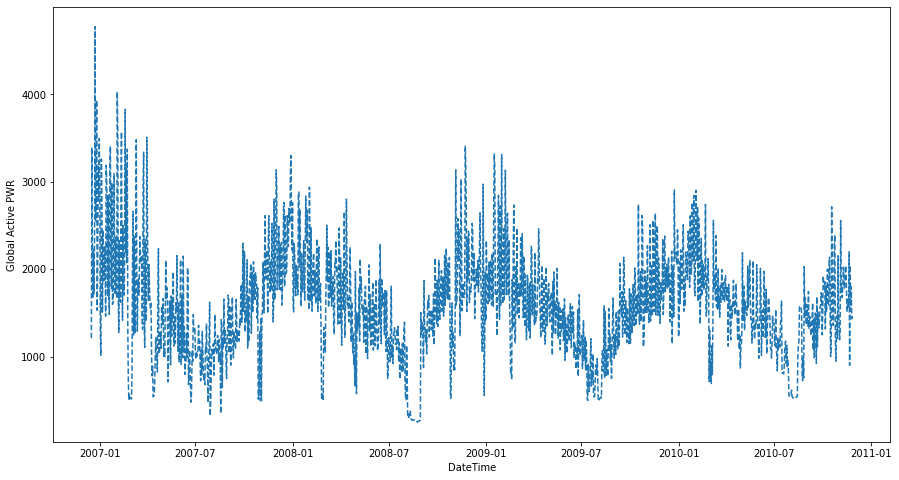

In [198]:
#global active power on daily time frame
plt.plot(daily_df.index, daily_df.Global_active_power,'--')
plt.xlabel('DateTime')
plt.ylabel('Global Active PWR')
plt.show()

In [199]:
from scipy.stats import pearsonr
pearsonr(df2['Global_reactive_power'],df2['Global_active_power'])

(0.24701705264406518, 0.0)

In [200]:
pearsonr(df2['Voltage'],df2['Global_intensity'])

(-0.41136307176847087, 0.0)

In [201]:
from fbprophet import Prophet

In [202]:
daily_df.reset_index(inplace=True)
daily_pro = daily_df[['datetime','Global_active_power']]

In [203]:
#renaming the columns 
daily_pro = daily_pro.rename(columns = {'datetime': 'ds','Global_active_power': 'y'})
print(daily_pro.shape)
daily_pro.head()

(1442, 2)


,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [204]:
train = daily_pro.iloc[:1077,:]
test = daily_pro.iloc[1077:,:]
print(train.shape)
print(test.shape)

(1077, 2)
(365, 2)


In [205]:
#fitting the model 
p_model = Prophet()
p_model.fit(train)
pred = p_model.predict(test)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [206]:
def MAPE_Metric(y_true,y_pred):
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) *100

In [207]:
mape = MAPE_Metric(test_set['y'],pred['yhat'])
print(f'the Mean Average Percentage Error (MAPE) is: {round(mape,3)} ')

the Mean Average Percentage Error (MAPE) is: 20.885 


In [208]:
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(np.array(test_set['y']),np.array(pred['yhat'])))

In [209]:
print('The Root Mean Square Error(rmse) value is : %s' %(round(rmse,1)))

The Root Mean Square Error(rmse) value is : 375.0


Figure(648x648)


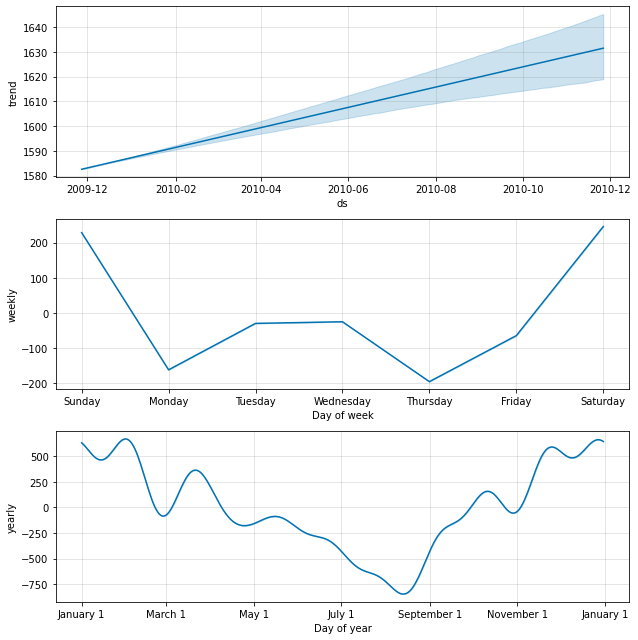

In [210]:
print(p_model.plot_components(pred))

In [211]:
# Resetting index column of the df_daily 
daily_df.reset_index(inplace = True)
multi_p = daily_df
print(multi_p.shape)
multi_p.head()

(1442, 9)


,index,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [212]:
multi_p = multi_p.rename(columns = {'datetime':'ds',
                                    'Global_active_power':'y',
                                    'Global_reactive_power':'add1',
                                     'Voltage':'add2',
                                    'Global_intensity':'add3',
                                    'Sub_metering_1':'add4',
                                    'Sub_metering_2':'add5',
                                    'Sub_metering_3':'add6'})

In [213]:
train = multi_p.iloc[:1077,:]
test = multi_p.iloc[1077:,:]
print(train.shape)
print(test.shape)

(1077, 9)
(365, 9)


In [214]:
m_model = Prophet()

In [215]:
m_model.add_regressor('add1')
m_model.add_regressor('add2')
m_model.add_regressor('add3')
m_model.add_regressor('add4')
m_model.add_regressor('add5')
m_model.add_regressor('add6')

In [216]:
m_model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [217]:
pred = m_model.predict(test)

In [218]:
mape = MAPE_Metric(test_set_multi['y'],pred['yhat'])
print('The Mean Average Percentage Error (MAPE) Is:%s' %round(mape,2)) # new value

The Mean Average Percentage Error (MAPE) Is:2.63


In [219]:

from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(np.array(test['y']),np.array(pred['yhat'])))
print('The Root Mean Square Error (RMSE) value Is : {}'.format(round(rmse,2)))

The Root Mean Square Error (RMSE) value Is : 39.13


Figure(648x864)


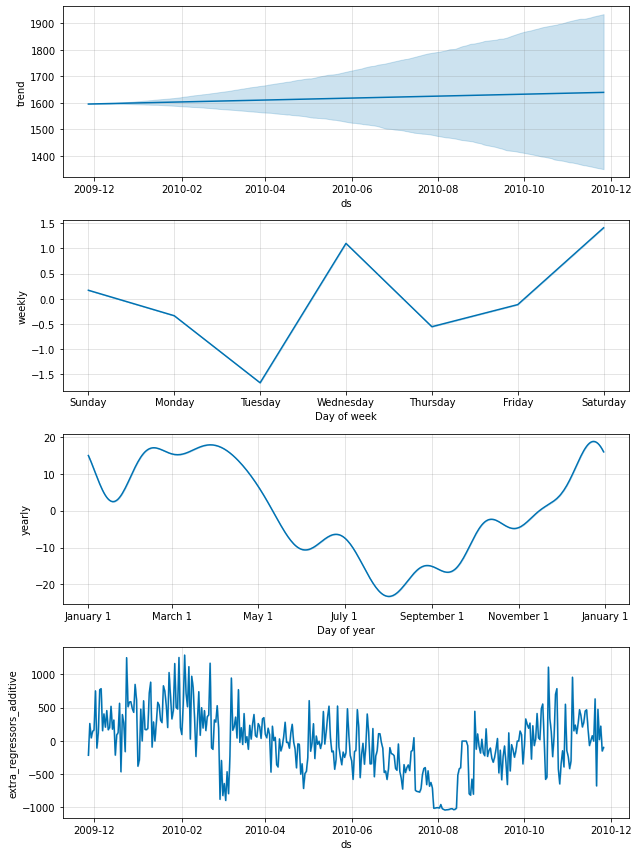

In [220]:
print(m_model.plot_components(m_pred))


Thank you